In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Best model observed from Wandb sweeps**

---

In [ ]:
from keras.layers import Dense, Embedding, Input, LSTM, GRU
from keras.callbacks import Callback
from keras.models import Sequential
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np

In [ ]:
def download_unzip():
    !wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
    !tar -xf dakshina_dataset_v1.0.tar
download_unzip()

--2021-05-19 19:00:02--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  35.9MB/s    in 17s     

2021-05-19 19:00:19 (112 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [ ]:
train_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_path =   "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"
num_samples = 50000

In [ ]:
max_encoder_seq_length = 0
max_decoder_seq_length = 0
num_encoder_tokens     = 0
num_decoder_tokens     = 0
input_token_index      = {}
arget_token_index      = {}
input_characters       = set()
target_characters      = set()
def Vectorize_Data(Data_path, isTrain):

  global input_characters, target_characters,  num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index
  input_texts       = []
  target_texts      = []
  input_characters  = set()
  target_characters = set()
  with open(Data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[: min(num_samples, len(lines) - 1)]:
    target_text, input_text, _ = line.split("\t")
    target_text = " " + target_text + " "
    input_text  = " " + input_text + " "
    input_texts.append(input_text)
    target_texts.append(target_text)
    if isTrain:
      for char in input_text:
          if char not in input_characters:
              input_characters.add(char)
      for char in target_text:
          if char not in target_characters:
              target_characters.add(char)
  if isTrain:
    input_characters       = sorted(list(input_characters))
    target_characters      = sorted(list(target_characters))
    num_encoder_tokens     = len(input_characters)
    num_decoder_tokens     = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input_texts])+1
    max_decoder_seq_length = max([len(txt) for txt in target_texts])+1

    input_token_index  = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

  encoder_input_data  = np.zeros((len(input_texts), max_encoder_seq_length), dtype = "float32")
  decoder_input_data  = np.zeros((len(input_texts), max_decoder_seq_length), dtype = "float32")
  decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = "float32")

  for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t]   =  input_token_index[char]
      encoder_input_data[i, t + 1 :] = input_token_index[" "]
      for t, char in enumerate(target_text):
          decoder_input_data[i, t]   = target_token_index[char]
          if t > 0:
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_input_data[i, t + 1 :] = target_token_index[" "]
      decoder_target_data[i, t:, target_token_index[" "]] = 1.0

  return input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
def RNN(layer, embedding_size, latent_dim, drop, attention):

  global Decoder_states
  Decoder_states = []
  layer -= 1
  encoder_input     = Input(shape=(max_encoder_seq_length,))
  encoder_embedding = Embedding(input_dim = num_encoder_tokens, output_dim = embedding_size)(encoder_input)

  encoder = GRU(latent_dim, return_state = True, return_sequences = True)
  outputs, state_h = encoder(encoder_embedding)
  Decoder_states.append([state_h])
  for i in range(layer):
      encoder_gru =  GRU(latent_dim, return_state = True, return_sequences = True, dropout = drop)
      outputs, state_h = encoder_gru(outputs)
      Decoder_states.append([state_h])

  decoder_input = Input(shape=(max_decoder_seq_length,))
  decoder_embedding = Embedding(input_dim = num_decoder_tokens, output_dim = embedding_size)(decoder_input)
  
  decoder = GRU(latent_dim, return_state = True, return_sequences = True)
  de_outputs, _ = decoder(decoder_embedding, initial_state = Decoder_states[0])
  for i in range(layer):
      decoder_gru = GRU(latent_dim, return_state = True, return_sequences = True, dropout = drop)
      de_outputs, state_h = decoder_gru(de_outputs, initial_state = Decoder_states[i+1])

  if attention == "yes":
      decoder_attention = keras.layers.AdditiveAttention(name = "decoder_attention")
      decoder_concat    = keras.layers.Concatenate(name = "decoder_concat")
      context_vec, attn_weights = decoder_attention([de_outputs, outputs], return_attention_scores = True)
      de_outputs = decoder_concat([de_outputs, context_vec])

  decoder_dense = Dense(num_decoder_tokens, activation = "softmax")
  decoder_outputs = decoder_dense(de_outputs)

  model = keras.Model([encoder_input, decoder_input], decoder_outputs)

  return model

In [ ]:
class PredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
      self.validation_data = validation_data
    def on_epoch_end(self, epoch, logs = {}):
      predictions = self.model.predict(self.validation_data[0])
      ground_truth = self.validation_data[1]
      one_hot_prediction = tf.one_hot(tf.argmax(predictions, axis=2), predictions.shape[2]).numpy()
      count = 0
      for i in range(len(predictions)):
        if np.array_equal(ground_truth[i], one_hot_prediction[i]):
          count += 1
      print("Word Level Val Accuracy: " + str(count/len(predictions)))

In [ ]:
def Test(drop, attention):
  input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data = Vectorize_Data(train_path, 1)
  input_texts_test, target_texts_test, encoder_input_data_test, decoder_input_data_test, decoder_target_data_test = Vectorize_Data(test_path, 0)
  model = RNN(layer = 3, embedding_size = 256, latent_dim = 128 , drop = drop, attention = attention)
  print(model.summary())
  for i, layer in enumerate(model.layers):
     print(i, layer)
  opt = keras.optimizers.Adam(learning_rate = 0.001)
  model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
  PC = PredictionCallback(validation_data = ([encoder_input_data_test, decoder_input_data_test], decoder_target_data_test))
  hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
        batch_size = 64,
        epochs = 30,
        shuffle = True,
        validation_data = ([encoder_input_data_test, decoder_input_data_test], decoder_target_data_test),
        callbacks =([PC]))
  return model

## Greedy search - Test accuracy on best model with attention and dropout of 0.3 and 0.5

---

In [ ]:
model1 = Test(0.3,'yes')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 23, 256)      6912        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 22, 256)      16384       input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
model2 = Test(0.5, 'yes')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 23, 256)      6912        input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 22, 256)      16384       input_4[0][0]                    
____________________________________________________________________________________________

## Greedy search - Test accuracy on best model without attention and dropout of 0.3 and 0.5

---

In [ ]:
model3 = Test(0.3, 'no')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 23, 256)      6912        input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 22, 256)      16384       input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
model4 = Test(0.5, 'no')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 23, 256)      6912        input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 22, 256)      16384       input_8[0][0]                    
____________________________________________________________________________________________

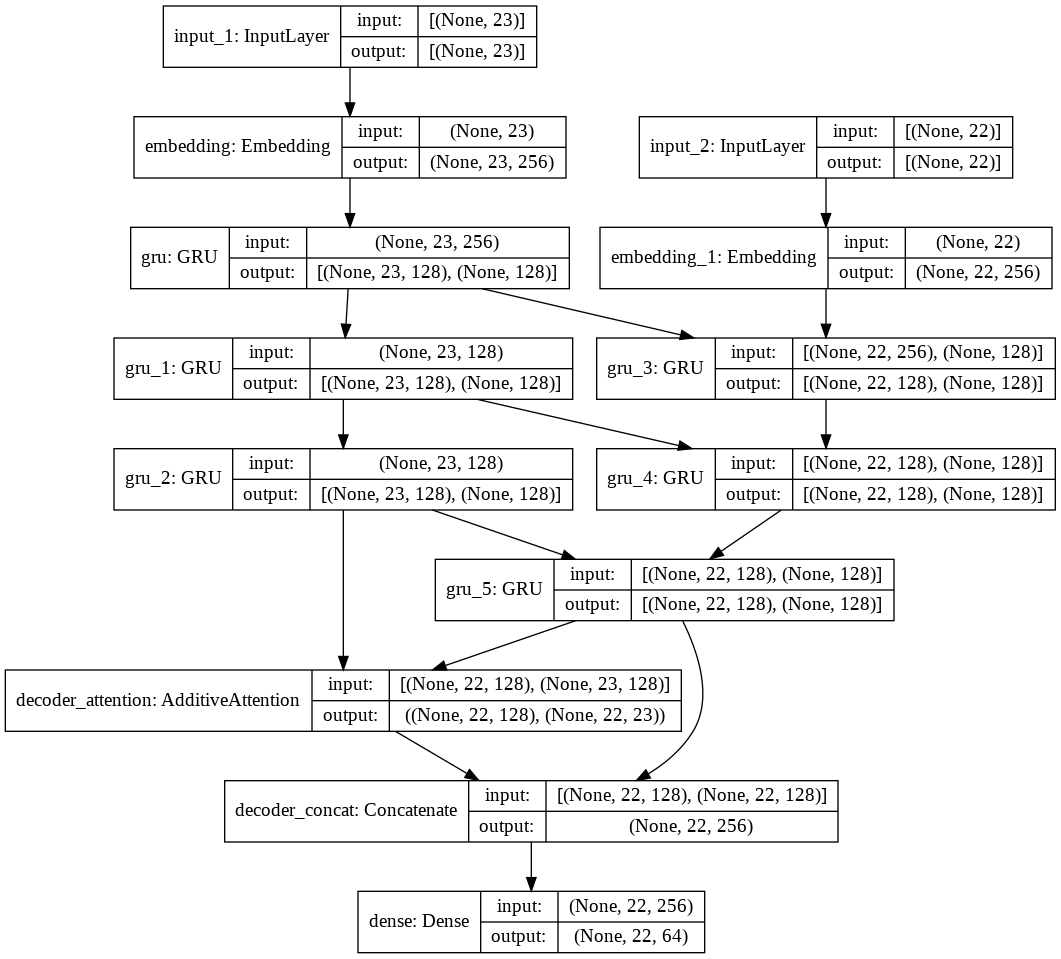

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes = True)

## Predictions

---

In [ ]:
input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data = Vectorize_Data(train_path, 1)
input_texts_val, target_texts_val, encoder_input_data_val, decoder_input_data_val, decoder_target_data_val = Vectorize_Data(val_path, 0)
input_texts_test, target_texts_test, encoder_input_data_test, decoder_input_data_test, decoder_target_data_test = Vectorize_Data(test_path, 0)


In [ ]:
def rebuild_model(model, attention, latent_dim):
  
  encoder_inputs = model.layers[0].output
  encoder_embedded = model.layers[2]
  encoder_outputs = encoder_embedded(encoder_inputs)
  encoder_states = []
  for i in range(3):
    encoder_outputs, state_h = model.layers[2*i + 4](encoder_outputs)
    encoder_states += [state_h]
  encoder_model = keras.Model(inputs=encoder_inputs, outputs = encoder_states + [encoder_outputs])

  decoder_inputs = model.layers[1].output
  decoder_embedded = model.layers[3]
  decoder_outputs = decoder_embedded(decoder_inputs)
  decoder_states_inputs = []
  decoder_states = []
  for i in range(3):
    current_state_inputs = [keras.Input(shape=(latent_dim,)) for _ in range(1)]
    decoder_outputs, state_h2 =  model.layers[(2*i + 1) + 4](decoder_outputs, initial_state = current_state_inputs)
    decoder_states += [state_h2]
    decoder_states_inputs += current_state_inputs
  decoder_hidden_state_input = keras.Input(shape=(max_encoder_seq_length , latent_dim))
  
  if attention == "yes":
    attention_layer = model.layers[10]
    attn_out_inf, attn_states_inf = attention_layer([decoder_outputs, decoder_hidden_state_input], return_attention_scores = True) 
    concatenate = model.layers[11]
    decoder_outputs = concatenate([decoder_outputs, attn_out_inf])

    attention_model = keras.Model(
      [decoder_inputs] + [decoder_hidden_state_input] + decoder_states_inputs,
      [attn_states_inf])
    
    decoder_dense = model.layers[12]
    decoder_outputs = decoder_dense(decoder_outputs) 
    decoder_model = keras.Model([decoder_inputs]  + decoder_states_inputs + [decoder_hidden_state_input], [decoder_outputs] + [decoder_states]) 
    return encoder_model , decoder_model, attention_model
    
  else:
    decoder_dense = model.layers[10]
    decoder_outputs = decoder_dense(decoder_outputs) 

    decoder_model = keras.Model([decoder_inputs]  + decoder_states_inputs + [decoder_hidden_state_input], [decoder_outputs] + [decoder_states]) 
    return encoder_model , decoder_model



In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

attent = []
def decode_sequence(input_seq):
    global attent
    attent = []
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index[" "]
    encoder_outputs = states_value[-1]
    encoder_states_value = states_value[:-1]
    stop_condition = False
    decoded_sentence = ""

    while not stop_condition:
        attent.append(attention_model.predict([target_seq] + [encoder_outputs] +  encoder_states_value)[0][0])
        output_decoder, decoder_states = decoder_model.predict([target_seq] + encoder_states_value + [encoder_outputs])
        
        sampled_token_index = np.argmax(output_decoder)
        sampled_char = reverse_target_char_index[sampled_token_index]
    
        if sampled_char == " " or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_sentence += sampled_char
      
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        encoder_states_value = decoder_states
    return decoded_sentence

In [ ]:
np.random.seed(123)
index = np.random.randint(0,len(input_texts_test), 20)
index

array([3582, 3454, 1346, 4060, 1593,   96, 4143, 4169,  942,  111, 3481,
       1363, 2894, 3325, 1092, 1847, 2050,   39, 1346, 1159])

In [ ]:
def print_results():
  for seq_index in index:
      input_sequence = encoder_input_data_test[seq_index : seq_index + 1]
      decoded_sentence = decode_sequence(input_sequence) 
      if (decoded_sentence.replace(" ","").strip() == target_texts_test[seq_index].replace(" ","").strip()):
        print("Correct")
      else : 
        print("Incorrect")
      print("---------")
      print("Input sentence:", input_texts_test[seq_index], " length= ", len(input_texts_test[seq_index]))
      print("output sentence:", target_texts_test[seq_index], " length= ", len(target_texts_test[seq_index]))
      print("Decoded sentence:", decoded_sentence.replace(" ","").strip())
      print("---------")

## Predictions without Beam Search

---

In [ ]:
from __future__ import print_function
import sys

In [ ]:
%%capture cap --no-stderr
# encoder_model , decoder_model, attention_model = rebuild_model(model1, 'yes', 128)
# print_results()
with open('predictions_attention.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
#Model1 : Attention, 0.3
encoder_model, decoder_model, attention_model = rebuild_model(model1, 'yes', 128)
print_results()


Incorrect
-
Input sentence:  lalak   length=  7
output sentence:  ललक   length=  5
Decoded sentence: लालक
---------

Incorrect
-
Input sentence:  retreate   length=  10
output sentence:  रीट्वीट   length=  9
Decoded sentence: रेट्रेट
---------

Correct
-
Input sentence:  jaanam   length=  8
output sentence:  जानम   length=  6
Decoded sentence: जानम
---------

Correct
-
Input sentence:  saptakranti   length=  13
output sentence:  सप्तक्रांति   length=  13
Decoded sentence: सप्तक्रांति
---------

Incorrect
-
Input sentence:  diphtheria   length=  12
output sentence:  डिप्थीरिया   length=  12
Decoded sentence: डिप्टेरिया
---------

Correct
-
Input sentence:  anik   length=  6
output sentence:  अनिक   length=  6
Decoded sentence: अनिक
---------

Correct
-
Input sentence:  sagrika   length=  9
output sentence:  सागरिका   length=  9
Decoded sentence: सागरिका
---------

Incorrect
-
Input sentence:  singar   length=  8
output sentence:  सिंगार   length=  8
Decoded sentence: सिंगर
---------

I

In [ ]:
%%capture cap --no-stderr
# encoder_model , decoder_model = rebuild_model(model3, 'no', 128)
# print_results()
with open('predictions_vanilla.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
#Model3 : Without Attention, 0.3
encoder_model , decoder_model = rebuild_model(model3, 'no', 128)
print_results()


Incorrect
-
Input sentence:  lalak   length=  7
output sentence:  ललक   length=  5
Decoded sentence: लालक
---------

Incorrect
-
Input sentence:  retreate   length=  10
output sentence:  रीट्वीट   length=  9
Decoded sentence: रेट्रेट
---------

Correct
-
Input sentence:  jaanam   length=  8
output sentence:  जानम   length=  6
Decoded sentence: जानम
---------

Incorrect
-
Input sentence:  saptakranti   length=  13
output sentence:  सप्तक्रांति   length=  13
Decoded sentence: सप्तरांत्ति
---------

Incorrect
-
Input sentence:  diphtheria   length=  12
output sentence:  डिप्थीरिया   length=  12
Decoded sentence: दिष्ठोरिया
---------

Correct
-
Input sentence:  anik   length=  6
output sentence:  अनिक   length=  6
Decoded sentence: अनिक
---------

Incorrect
-
Input sentence:  sagrika   length=  9
output sentence:  सागरिका   length=  9
Decoded sentence: साग्रिका
---------

Incorrect
-
Input sentence:  singar   length=  8
output sentence:  सिंगार   length=  8
Decoded sentence: सिंगर
-------

## Predictions with Beam Search

---

In [ ]:
def beam_search_decoder(data, top_k = 3):
  
  top_k_predictions = np.zeros((len(data), top_k, data.shape[1]), dtype="int32")
  
  for k, predictions in enumerate(data):
    output_sequences = [([], 0)]
    for token_probs in predictions:
        new_sequences = []

        for old_seq, old_score in output_sequences:
            for char_index in range(len(token_probs)):
                new_seq = old_seq + [char_index]
                new_score = old_score + np.math.log(token_probs[char_index])
                new_sequences.append((new_seq, new_score))
        output_sequences = sorted(new_sequences, key = lambda val: val[1], reverse = True)
        output_sequences = output_sequences[:top_k]

    for i in range(top_k):
        top_k_predictions[k][i] = output_sequences[i][0]

  return top_k_predictions

In [ ]:
class PredictionCallback1(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data):
      self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs = {}):
      predictions = self.model.predict(self.validation_data[0])
      ground_truth = self.validation_data[1]

      top_k_predictions = beam_search_decoder(predictions, 3)
      count = 0
      for i in range(len(predictions)):
        
        for j in range(3):
        
          one_hot_prediction = tf.one_hot(top_k_predictions[i][j], predictions.shape[2]).numpy()
          if np.array_equal(ground_truth[i], one_hot_prediction):
            count += 1
            break

      print("Word Level Val Accuracy: " + str(count/len(predictions)))
      

In [ ]:
def Test_with_beam(attention):
  input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data = Vectorize_Data(train_path, 1)
  input_texts_test, target_texts_test, encoder_input_data_test, decoder_input_data_test, decoder_target_data_test = Vectorize_Data(test_path, 0)
  model = RNN(layer = 3, embedding_size = 256, latent_dim = 128 , drop = 0.3, attention = attention)
  print(model.summary())
  for i, layer in enumerate(model.layers):
     print(i, layer)
  opt = keras.optimizers.Adam(learning_rate = 0.001)
  model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
  PC = PredictionCallback1(validation_data = ([encoder_input_data_test, decoder_input_data_test], decoder_target_data_test))
  hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
        batch_size = 64,
        epochs = 30,
        shuffle = True,
        validation_data = ([encoder_input_data_test, decoder_input_data_test], decoder_target_data_test),
        callbacks =([PC]))
  return model

In [ ]:
#With Attention
model_beam1 = Test_with_beam('yes')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 23, 256)      6912        input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 22, 256)      16384       input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
%%capture cap --no-stderr
encoder_model , decoder_model, attention_model = rebuild_model(model_beam1, 'yes', 128)
print_results()
with open('predictions_attention_beam.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
#Predictions of model with beam search and Attention
encoder_model, decoder_model, attention_model = rebuild_model(model_beam1, 'yes', 128)
print_results()


Incorrect
-
Input sentence:  lalak   length=  7
output sentence:  ललक   length=  5
Decoded sentence: लालक
---------

Incorrect
-
Input sentence:  retreate   length=  10
output sentence:  रीट्वीट   length=  9
Decoded sentence: रेट्रेट
---------

Correct
-
Input sentence:  jaanam   length=  8
output sentence:  जानम   length=  6
Decoded sentence: जानम
---------

Incorrect
-
Input sentence:  saptakranti   length=  13
output sentence:  सप्तक्रांति   length=  13
Decoded sentence: सप्ताकृति
---------

Incorrect
-
Input sentence:  diphtheria   length=  12
output sentence:  डिप्थीरिया   length=  12
Decoded sentence: दिफ्तेरिया
---------

Correct
-
Input sentence:  anik   length=  6
output sentence:  अनिक   length=  6
Decoded sentence: अनिक
---------

Correct
-
Input sentence:  sagrika   length=  9
output sentence:  सागरिका   length=  9
Decoded sentence: सागरिका
---------

Incorrect
-
Input sentence:  singar   length=  8
output sentence:  सिंगार   length=  8
Decoded sentence: सिंगर
---------

I

In [ ]:
#Without Attention
model_beam2 = Test_with_beam('no')

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 23, 256)      6912        input_21[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 22, 256)      16384       input_22[0][0]                   
___________________________________________________________________________________________

In [ ]:
%%capture cap --no-stderr
encoder_model , decoder_model = rebuild_model(model_beam2, 'no', 128)
print_results()
with open('predictions_vanilla_beam.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
#Predictions of model with beam search and without Attention
encoder_model, decoder_model = rebuild_model(model_beam2, 'no', 128)
print_results()


Incorrect
-
Input sentence:  lalak   length=  7
output sentence:  ललक   length=  5
Decoded sentence: लालक
---------

Incorrect
-
Input sentence:  retreate   length=  10
output sentence:  रीट्वीट   length=  9
Decoded sentence: रेट्रेट
---------

Correct
-
Input sentence:  jaanam   length=  8
output sentence:  जानम   length=  6
Decoded sentence: जानम
---------

Incorrect
-
Input sentence:  saptakranti   length=  13
output sentence:  सप्तक्रांति   length=  13
Decoded sentence: सप्तकर्ति
---------

Incorrect
-
Input sentence:  diphtheria   length=  12
output sentence:  डिप्थीरिया   length=  12
Decoded sentence: दिश्थेरेय
---------

Correct
-
Input sentence:  anik   length=  6
output sentence:  अनिक   length=  6
Decoded sentence: अनिक
---------

Incorrect
-
Input sentence:  sagrika   length=  9
output sentence:  सागरिका   length=  9
Decoded sentence: साग्रिका
---------

Correct
-
Input sentence:  singar   length=  8
output sentence:  सिंगार   length=  8
Decoded sentence: सिंगार
---------



## Attention Heatmaps

---

In [ ]:
#With Attention
model_beam1 = Test_with_beam('yes')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 23, 256)      6912        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 22, 256)      16384       input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
from keras.models import model_from_json
import h5py
import json

In [ ]:
with h5py.File("model_beam_attn.hdf5", "w") as f:
    dset = f.create_dataset("mydataset", (100,), dtype='i')

In [ ]:
#Serialize to JSON
json_file = model_beam1.to_json()
with open('model_beam_attn.json', "w") as file:
   file.write(json_file)
#Serialize weights to HDF5
model_beam1.save_weights('model_beam_attn.hdf5')

In [ ]:
#Load and create model
json_file = open('/content/drive/MyDrive/DL_Assignment 3/model_beam_attn.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

#Load weights into new model
model.load_weights("/content/drive/MyDrive/DL_Assignment 3/model_beam_attn.hdf5")

In [ ]:
from matplotlib.font_manager import FontProperties as fp
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

In [ ]:
!wget "https://www.fontmirror.com/app_public/files/t/1/2020/04/MANGAL.TTF"

--2021-05-19 19:02:36--  https://www.fontmirror.com/app_public/files/t/1/2020/04/MANGAL.TTF
Resolving www.fontmirror.com (www.fontmirror.com)... 142.93.191.180
Connecting to www.fontmirror.com (www.fontmirror.com)|142.93.191.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143864 (140K) [application/x-font-ttf]
Saving to: ‘MANGAL.TTF.1’

MANGAL.TTF.1        100%[===================>] 140.49K   800KB/s    in 0.2s    

2021-05-19 19:02:37 (800 KB/s) - ‘MANGAL.TTF.1’ saved [143864/143864]



In [ ]:
reverse_target_char_index

In [ ]:
def attention_heatmap(attent, predLen, pred, actualLen, actual, seq_index):
    myfig = plt.figure(figsize=(5,5))
    ax = myfig.add_subplot(1, 1, 1)
    attent = np.array(attent)
    viram=["VIRAM"]
    VIRAM =[reverse_target_char_index[51]+reverse_target_char_index[44]+reverse_target_char_index[42]+reverse_target_char_index[50]+reverse_target_char_index[40]]
    draw = ax.matshow(attent[:, 1:actualLen+1], cmap='magma')
    myfig.colorbar(draw)
    ax.set_xticklabels([''] + list(actual[1:-1]) + viram, fontdict={'fontsize': 18}, rotation=90)
    ax.set_yticklabels([''] + list(pred) + VIRAM, fontdict={'fontsize': 18}, fontproperties=fp(fname='MANGAL.TTF', size=18))
    ax.xaxis.set_major_locator(tick.MultipleLocator(1))
    ax.yaxis.set_major_locator(tick.MultipleLocator(1))
    plt.savefig('saved_figure'+str(seq_index)+'.png')
    # plt.show()

In [ ]:
def print_res():
  predLen   = 0
  actualLen = 0
  pred      = " "
  actual    = " "
  for seq_index in index:
      input_sequence = encoder_input_data_test[seq_index : seq_index + 1]
      decoded_sentence = decode_sequence(input_sequence)
      if (decoded_sentence.replace(" ","").strip() == target_texts_test[seq_index].replace(" ","").strip()):
        print("Correct")
      else : 
        print("Incorrect")
      print("---------")
      print("Input sentence:", input_texts_test[seq_index], " length= ", len(input_texts_test[seq_index]))
      print("output sentence:", target_texts_test[seq_index], " length= ", len(target_texts_test[seq_index]))
      print("Decoded sentence:", decoded_sentence.replace(" ","").strip())
      print("---------")
      actualLen = len(input_texts_test[seq_index]) - 1
      actual    = input_texts_test[seq_index]
      predLen   = len(decoded_sentence.replace(" ","").strip())
      pred      = decoded_sentence.replace(" ","").strip()
      attention_heatmap(attent, predLen, pred, actualLen, actual, seq_index)
      


Incorrect
---------
Input sentence:  lalak   length=  7
output sentence:  ललक   length=  5
Decoded sentence: लालक
---------


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)



Incorrect
---------
Input sentence:  retreate   length=  10
output sentence:  रीट्वीट   length=  9
Decoded sentence: रेट्रेट
---------

Correct
---------
Input sentence:  jaanam   length=  8
output sentence:  जानम   length=  6
Decoded sentence: जानम
---------

Incorrect
---------
Input sentence:  saptakranti   length=  13
output sentence:  सप्तक्रांति   length=  13
Decoded sentence: सप्तकृंति
---------

Incorrect
---------
Input sentence:  diphtheria   length=  12
output sentence:  डिप्थीरिया   length=  12
Decoded sentence: दिफ़थिरा
---------

Correct
---------
Input sentence:  anik   length=  6
output sentence:  अनिक   length=  6
Decoded sentence: अनिक
---------

Incorrect
---------
Input sentence:  sagrika   length=  9
output sentence:  सागरिका   length=  9
Decoded sentence: सगरीका
---------

Incorrect
---------
Input sentence:  singar   length=  8
output sentence:  सिंगार   length=  8
Decoded sentence: सिंगर
---------

Incorrect
---------
Input sentence:  khuda   length=  7
output 

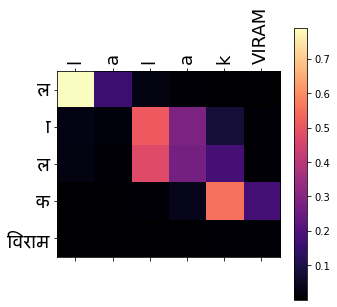

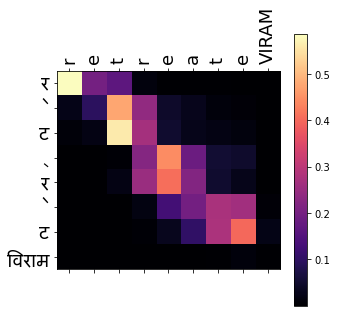

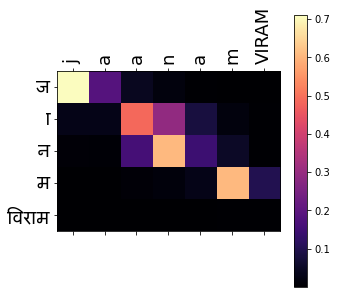

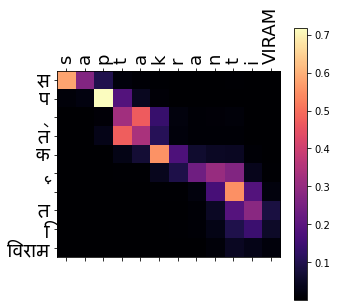

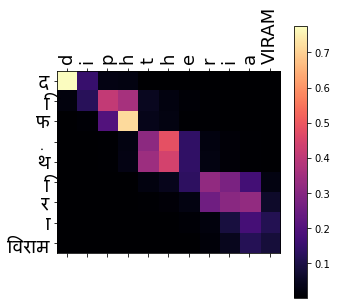

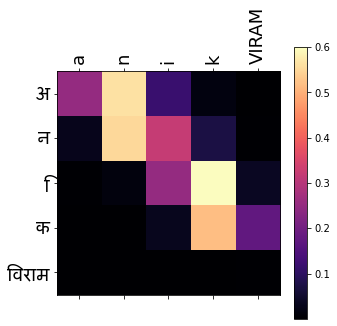

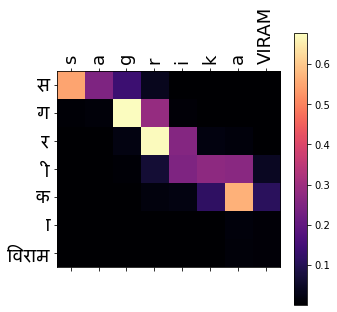

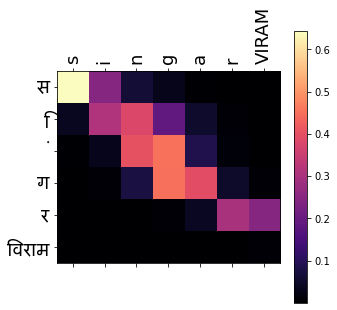

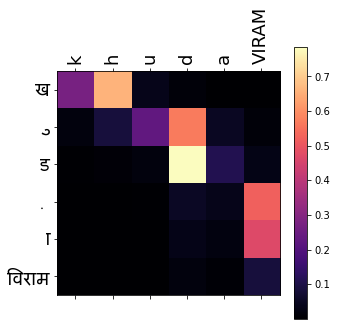

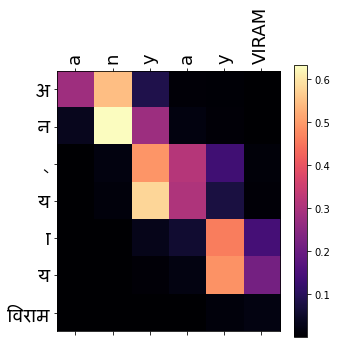

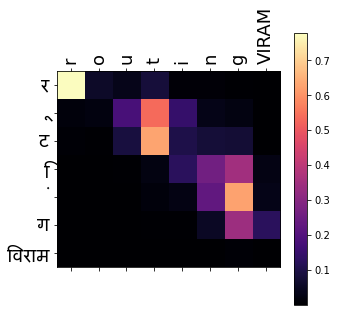

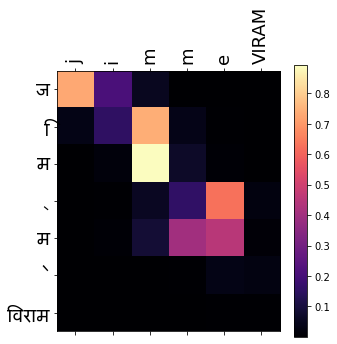

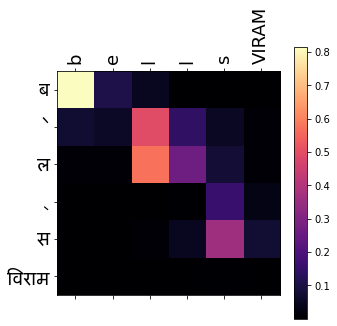

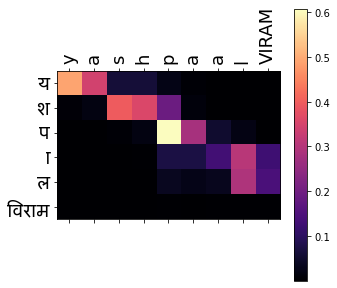

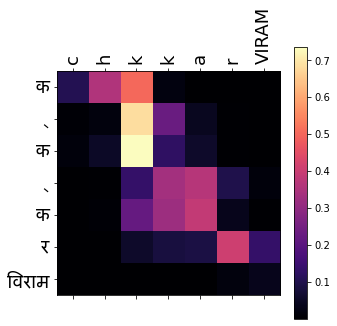

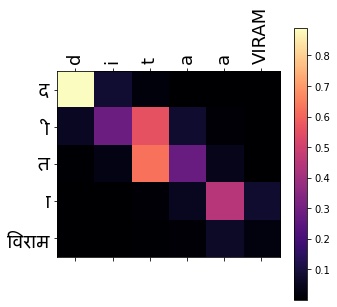

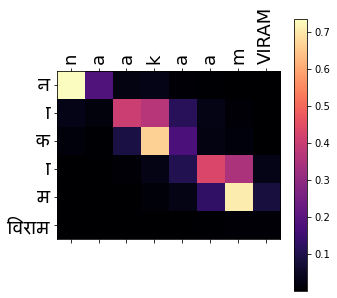

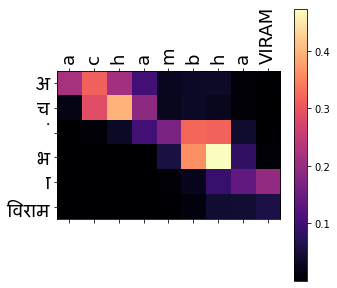

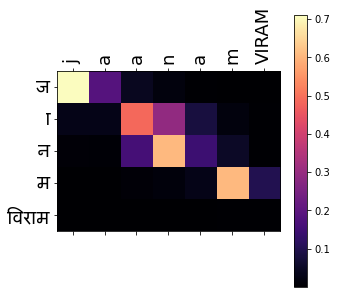

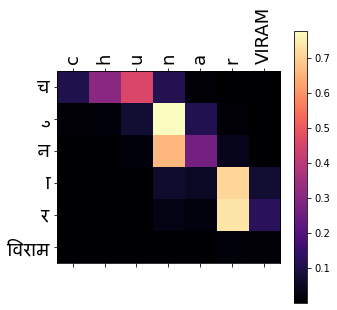

In [ ]:
encoder_model , decoder_model, attention_model = rebuild_model(model, 'yes', 128)
print_res()